## Imports

In [3]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [4]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [5]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.6002, 0.4961, 0.3605], std=[0.2681, 0.2808, 0.2984]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [6]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Display All Loss & Accuracy Curves on a Single Plot

In [20]:
# Load the LinearSVM model.

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
PATH = "../saved_models/food/linear_svm/baseline.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/linear_svm/baseline-history.pt')
LOSS_SVM, ACC_SVM, LOSS_V_SVM, ACC_V_SVM = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

print(len(LOSS_SVM))

50


In [21]:
# Load the Conv4 model.

PATH = "../saved_models/food/conv4/baseline.pt"
loaded_model = torch.load(PATH)
# loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/conv4/baseline-history.pt')
LOSS_CONV, ACC_CONV, LOSS_V_CONV, ACC_V_CONV = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

print(len(LOSS_CONV))

10


In [22]:
# Load the VGG16 model.
PATH = "../saved_models/food/vgg16/vgg16.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/vgg16/vgg16-history.pt')
LOSS_VGG, ACC_VGG, LOSS_V_VGG, ACC_V_VGG = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

print(len(LOSS_VGG))

50


In [31]:
# Load the Res18 model.

PATH = "../saved_models/food/res18/res18-unfreeze.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/res18/res18-unfreeze-history.pt')
LOSS_RES, ACC_RES, LOSS_V_RES, ACC_V_RES = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

print(len(LOSS_RES))

20


In [24]:
# Load the DenseNet model.

PATH = "../saved_models/food/densenet/densenet.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/densenet/densenet-history.pt')
LOSS_DENSE, ACC_DENSE, LOSS_V_DENSE, ACC_V_DENSE = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

print(len(LOSS_DENSE))

20


In [34]:
# Load the ResNext model.
PATH = "../saved_models/food/resnext/resnext.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history_1 = torch.load('../saved_models/food/resnext/resnext-history.pt')
history_2 = torch.load('../saved_models/food/resnext/resnext-history-part2.pt')
LOSS_1, ACC_1, LOSS_V_1, ACC_V_1 = (history_1['loss'], history_1['acc'], history_1['loss_v'], history_1['acc_v'])
LOSS_2, ACC_2, LOSS_V_2, ACC_V_2 = (history_2['loss'], history_2['acc'], history_2['loss_v'], history_2['acc_v'])

LOSS_RESNEXT = LOSS_1 + LOSS_2
ACC_RESNEXT = ACC_1 + ACC_2
LOSS_V_RESNEXT = LOSS_V_1 + LOSS_V_2
ACC_V_RESNEXT = ACC_V_1 + ACC_V_2
print(len(LOSS_RESNEXT))

10


In [40]:
# Load the MultiTask model.

class MultiModal(nn.Module):
    def __init__(self, resnet):
        super(MultiModal, self).__init__()
        self.resnet = resnet
        self.relu = nn.ReLU()
        self.food = nn.Linear(1000, 172) # nn.Sequential(nn.Linear(1000, 4096), nn.ReLU(), nn.Dropout(), nn.Linear(4096, 172))
        self.ingredients = nn.Sequential(nn.Linear(1000, 353), nn.Sigmoid()) # nn.Sequential(nn.Linear(1000, 1024), nn.ReLU(), nn.Dropout(), nn.Linear(1024, 353), nn.Sigmoid())

    def forward(self, x):
        a = self.resnet(x)
        b = self.relu(a)
        food_output = self.food(b)
        ingredient_output = self.ingredients(b)
        return (food_output, ingredient_output)

PATH = "../saved_models/ingredients/multi_modal/multi_modal.dat"
model = torch.load(PATH)

results = torch.load('../saved_models/ingredients/multi_modal/multi_modal-results.pt')
train_results, val_results = results['train'], results['val']
LOSS_MM, ACC_MM, LOSS_V_MM, ACC_V_MM = (train_results['loss_history'], train_results['food_accuracy_history'], 
                                            val_results['loss_history'], val_results['food_accuracy_history'])

print(len(LOSS_MM))

10


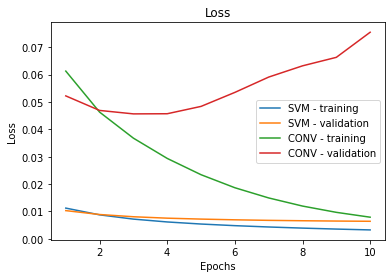

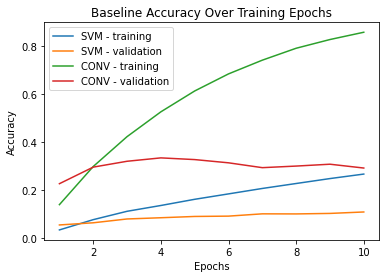

Final SVM Training Accuracy:  tensor(0.8791, device='cuda:0')
Final SVM Validation Accuracy:  tensor(0.1260, device='cuda:0')
Final CONV Training Accuracy:  tensor(0.8569, device='cuda:0')
Final SVM Validation Accuracy:  tensor(0.2925, device='cuda:0')


In [29]:
# Plot both baselines on a SINGLE plot

epochs = 10

plt.figure()
E = np.arange(epochs)+1
plt.plot(E,LOSS_SVM[:epochs],label='SVM - training')
plt.plot(E,LOSS_V_SVM[:epochs],label='SVM - validation')
plt.plot(E,LOSS_CONV[:epochs],label='CONV - training')
plt.plot(E,LOSS_V_CONV[:epochs],label='CONV - validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC_SVM[:epochs],label='SVM - training')
plt.plot(E,ACC_V_SVM[:epochs],label='SVM - validation')
plt.plot(E,ACC_CONV[:epochs],label='CONV - training')
plt.plot(E,ACC_V_CONV[:epochs],label='CONV - validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Baseline Accuracy Over Training Epochs")
plt.legend()
plt.show()
print("Final SVM Training Accuracy: ", ACC_SVM[-1])
print("Final SVM Validation Accuracy: ", ACC_V_SVM[-1])
print("Final CONV Training Accuracy: ", ACC_CONV[-1])
print("Final SVM Validation Accuracy: ", ACC_V_CONV[-1])

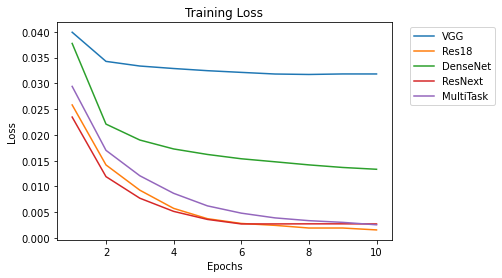

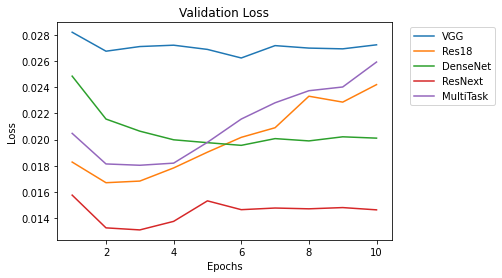

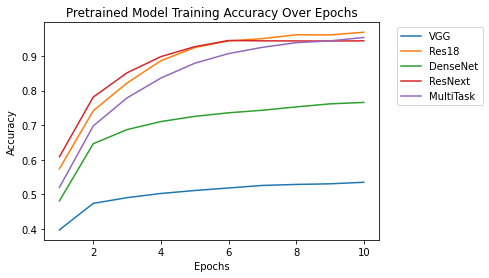

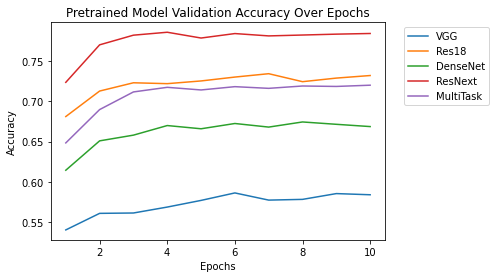

Final VGG16 Training Accuracy:  tensor(0.5715, device='cuda:0')
Final VGG16 Validation Accuracy:  tensor(0.5955, device='cuda:0')
Final Res18 Training Accuracy:  tensor(0.9822, device='cuda:0')
Final Res18 Validation Accuracy:  tensor(0.7368, device='cuda:0')
Final DenseNet Training Accuracy:  tensor(0.7931, device='cuda:0')
Final DenseNet Validation Accuracy:  tensor(0.6668, device='cuda:0')
Final ResNext Training Accuracy:  tensor(0.9434, device='cuda:0')
Final ResNext Validation Accuracy:  tensor(0.7840, device='cuda:0')
Final MultiTask Training Accuracy:  tensor(0.9530, device='cuda:0')
Final MultiTask Validation Accuracy:  tensor(0.7199, device='cuda:0')


In [42]:
# Plot deep models on a SINGLE plot

epochs = 10

plt.figure()
E = np.arange(epochs)+1

plt.plot(E,LOSS_VGG[:epochs],label='VGG')
plt.plot(E,LOSS_RES[:epochs],label='Res18')
plt.plot(E,LOSS_DENSE[:epochs],label='DenseNet')
plt.plot(E,LOSS_RESNEXT[:epochs],label='ResNext')
plt.plot(E,LOSS_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,LOSS_V_VGG[:epochs],label='VGG')
plt.plot(E,LOSS_V_RES[:epochs],label='Res18')
plt.plot(E,LOSS_V_DENSE[:epochs],label='DenseNet')
plt.plot(E,LOSS_V_RESNEXT[:epochs],label='ResNext')
plt.plot(E,LOSS_V_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,ACC_VGG[:epochs],label='VGG')
plt.plot(E,ACC_RES[:epochs],label='Res18')
plt.plot(E,ACC_DENSE[:epochs],label='DenseNet')
plt.plot(E,ACC_RESNEXT[:epochs],label='ResNext')
plt.plot(E,ACC_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pretrained Model Training Accuracy Over Epochs")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()
plt.figure()

plt.plot(E,ACC_V_VGG[:epochs],label='VGG')
plt.plot(E,ACC_V_RES[:epochs],label='Res18')
plt.plot(E,ACC_V_DENSE[:epochs],label='DenseNet')
plt.plot(E,ACC_V_RESNEXT[:epochs],label='ResNext')
plt.plot(E,ACC_V_MM[:epochs],label='MultiTask')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pretrained Model Validation Accuracy Over Epochs")
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

print("Final VGG16 Training Accuracy: ", ACC_VGG[-1])
print("Final VGG16 Validation Accuracy: ", ACC_V_VGG[-1])
print("Final Res18 Training Accuracy: ", ACC_RES[-1])
print("Final Res18 Validation Accuracy: ", ACC_V_RES[-1])
print("Final DenseNet Training Accuracy: ", ACC_DENSE[-1])
print("Final DenseNet Validation Accuracy: ", ACC_V_DENSE[-1])
print("Final ResNext Training Accuracy: ", ACC_RESNEXT[-1])
print("Final ResNext Validation Accuracy: ", ACC_V_RESNEXT[-1])
print("Final MultiTask Training Accuracy: ", ACC_MM[-1])
print("Final MultiTask Validation Accuracy: ", ACC_V_MM[-1])